# Project 5: Capstone Project
### Learning to Trade Using Q-Learning
<sub>Uirá Caiado. Aug 10, 2016<sub>


#### Abstract

*In this project, I will present an adaptive learning model to trade a single stock under the reinforcement learning framework. This area of machine learning consists in training an agent by reward and punishment without needing to specify the expected action. The agent learns from its experience and develops a strategy that maximizes its profits. "The simulation results show initial success in bringing learning techniques to build algorithmic trading strategies".[to be checked]*

## 1. Introduction

In this section, I will provide a high-level overview of the project, define the problem addressed and the metric used to measure the performance of the model created.

### 1.1. Project Overview
```
Udacity:

In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
- Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?
- Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?
```
Nowadays, algo trading represents almost half of all cash equity trading in western Europe. In advanced markets, it already [accounts](http://en.resenhadabolsa.com.br/portfolio-category/the-distributionintermediation-industry-in-brazil-challenges-and-trends/) for over 40%-50% of total volume. In Brazil its market share is not as large – currently about 10% – but is expected to rise in the years ahead as markets and players go digital.

As automated strategies are becoming increasingly popular, building an intelligent system that can trade many times a day and adapts itself to the market conditions and still consistently makes money is a subject of keen interest of any market participant.

Given that it is hard to produce such strategy, in this project I will try to build an algorithm that just does better than a random agent, but learns by itself how to trade. To do so, I will feed my agent with one month of information about every trade and change in the [top of the order book](https://goo.gl/k1dDYZ) in the [PETR4](https://pt.wikipedia.org/wiki/Petrobras) - one of the most liquidity assets in Brazilian Stock Market - in a Reinforcement Learning Framework. Later on, I will test what it has learned in a newest dataset.

The dataset used in this project is also known as [level I order book data](https://www.thebalance.com/order-book-level-2-market-data-and-depth-of-market-1031118) and includes all trades and changes in the prices and total quantities at best Bid (those who wants to buy the stock) and Offer side (those who intends to sell the stock).


### 1.2. Problem Statement
```
Udacity:

In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?
- Have you thoroughly discussed how you will attempt to solve the problem?
- Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?
```
[Algo trading](http://goo.gl/b9jAqE) strategies usually are programs that follow a predefined set of instructions to place its orders. The primary challenge to this approach is building these rules in a way that it can consistently generate profit without being too sensitive to market conditions. 

Thus, the goal of this project is to develop an adaptative learning model that can learn by itself those rules and trade a particular asset using reinforcement learning framework under an environment that replays historical high-frequency data.

As \cite{chan2001electronic} describe, reinforcement learning can be considered as a model-free approximation of dynamic programming. The knowledge of the underlying processes is not assumed but learned from experience.

The agent can access some information about the environment state as the order flow imbalance, the sizes of the best bid and offer and so on. At each time step $t$, It should generate some valid action, as buy stocks or insert a limit order at the Ask side. All inputs and actions will be detailed in the next sections.

The agent also should receive a reward or a penalty at each time step if it is already carrying a position from previous rounds or if it has made a trade (the cost of the operations are computed as a penalty).

Based on the rewards and penalties it gets, the agent should learn an optimal policy for trade this particular stock, maximizing the profit it receives from its actions and resulting positions.





### 1.3. Metrics
```
Udacity:

In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?
- Have you provided reasonable justification for the metrics chosen based on the problem and solution?
```

In 1988, the Wall Street Journal created a [Dartboard Contest](http://www.automaticfinances.com/monkey-stock-picking/), where Journal staffers threw darts at a stock table to select their assets, while investment experts picked their own stocks. After six months, they compared the results of the two methods. After adjusting the results to risk level, they found out that the pros barely have beaten the random pickers.

Given that, the metric used to measure the performance of the learner will be the amount of money made by a random agent. So, my goal will be to outperform this agent, that should just produce some random action from a set of allowed action at each time $t$. In the next section, I will detail the behavior of this agent.

## 2. Analysis

In this section, I will explore the data set that will be used in the simulation, define and justify the inputs employed in the state representation of the algorithm, explain the reinforcement learning techniques used and provide a benchmark.

### 2.1. Data Exploration
```
Udacity:

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?
- If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?
- If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?
- Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)
```
The dataset used is composed by level I order book data from PETR4, a stock traded at BMFBovespa Stock Exchange. Includes 19 trading sessions from 07/25/2016 to 08/18/2016. I will use one day to create the scalers of the features used, that I shall explain. Then, I will use 16 days to train the model and finally, I will test the policy found in the last two days. The data was collected from Bloomberg. *Let's start by looking at the size of these files:*

In [5]:
import zipfile
s_fname = "data/petr4_0725_0818_2.zip"
archive = zipfile.ZipFile(s_fname, 'r')
def foo():
    f_total = 0.
    f_tot_rows = 0.
    for i, x in enumerate(archive.infolist()):
        f_total += x.file_size/ 1024.**2
        for num_rows, row in enumerate(archive.open(x)):
            f_tot_rows += 1
        print "{}:\t{:,.0f} rows\t{:0.2f} MB".format(x.filename, num_rows + 1, x.file_size/ 1024.**2)
    print '=' * 42
    print "TOTAL\t\t{} files\t{:0.2f} MB".format(i+1,f_total)
    print "\t\t{:0,.0f} rows".format(f_tot_rows)

%time foo()

20160725.csv:	110,756 rows	4.42 MB
20160726.csv:	100,109 rows	3.98 MB
20160727.csv:	123,175 rows	4.93 MB
20160728.csv:	109,655 rows	4.37 MB
20160729.csv:	135,111 rows	5.40 MB
20160801.csv:	109,710 rows	4.37 MB
20160802.csv:	108,053 rows	4.30 MB
20160803.csv:	137,039 rows	5.49 MB
20160804.csv:	139,118 rows	5.56 MB
20160805.csv:	112,852 rows	4.51 MB
20160808.csv:	89,730 rows	3.55 MB
20160809.csv:	83,826 rows	3.33 MB
20160810.csv:	105,758 rows	4.21 MB
20160811.csv:	144,728 rows	5.81 MB
20160812.csv:	147,086 rows	5.90 MB
20160815.csv:	108,633 rows	4.33 MB
20160816.csv:	108,795 rows	4.33 MB
20160817.csv:	118,980 rows	4.75 MB
20160818.csv:	84,489 rows	3.36 MB
TOTAL		19 files	86.90 MB
		2,177,603 rows
CPU times: user 7.36 s, sys: 55.9 ms, total: 7.41 s
Wall time: 7.49 s


There are 19 files, each one has 110,000 rows on average, resulting in 2,117,603 row at total and more than 86 MB of information. Now, let's look at the structure of one of them:

In [8]:
import pandas as pd
l_fnames = archive.infolist()
df = pd.read_csv(archive.open(l_fnames[0]), index_col=0, parse_dates=['Date'])
df.head()

,Date,Type,Price,Size
0,2016-07-25 10:02:00,TRADE,11.98,5800
1,2016-07-25 10:02:00,BID,11.97,6100
2,2016-07-25 10:02:00,ASK,11.98,51800
3,2016-07-25 10:02:00,ASK,11.98,56800
4,2016-07-25 10:02:00,ASK,11.98,56900


Each file is composed of four different fields. The column $Date$ is the timestamp of the row and has a precision of seconds. $Type$ is the kind of information that the row encompasses. The type "TRADE" relates to an actual trade that has happened. "BID" is related to changes in the best Bid level and "ASK," to the best Offer level. $Price$ is the current best bid or ask and $Size$ is the cumulated quantity on that price and side.

All this data will be used to create the environment where my agent will operate. This environment is an order book, where the agent will be able to insert new orders or execute trades at the best prices. The environment will answer with the agent's current position and Profit and Loss (PnL). The cost of the trade will be account as a penalty.

As \cite{chan2001electronic} explained, Markov decision processes (MDPs) are the most common model for reinforcement learning.  The MDP model of the environment consists, among other things, of a discrete set of states $S$ and a discrete set of actions $A$ the agent can take. There are six possible action:

$$a_t \in \left (None,\, buy,\, sell,\, best\_bid,\, best\_ask,\, best\_both \right)$$

Where $None$ indicates that the agent shouldn't have any order in the market. $Buy$ and $Sell$ mean that the agent should execute a market order to buy or sell $100$ stocks (the size of an order will always be a hundred shares). $best\_bid$ and $best\_ask$ indicates that the agent should keep order at the best price just in the mentioned side and $best\_both$, it should have orders at the best price in both sides.

The current state of the environment will be represented by a set of variables that includes variables that relates to the events that has occured at the last minutes and other variables that describe the last state of the order book. So, I will use the following inputs to represent teh satte of the environment:

- $qAggr$: integer. The net quantity that was traded at each side in the last 2 minutes. 
- $Log\_Return$: float. The Log return of the stock in the last 2 minutes
- $qOFI$: integer. The Order Flow Imbalance in the last 2 minutes
- $qBid$: Integer. The size of the current best Bid
- $book\_ratio$: float. The Bid size over the Ask size
- $nChanges$: integer. The number of changes in the best prices in the last 2 minutes



The size of the Ask is not used because it is indirectaly used in the $book\_ratio$.

There are many ways to measure the ORder Flow Imbalance (OFI). The method use in this project was proposed by \cite{}.


```
Udacity:

Exploratory Visualization:

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- Have you visualized a relevant characteristic or feature about the dataset or input data?
- Is the visualization thoroughly analyzed and discussed?
- If a plot is provided, are the axes, title, and datum clearly defined?
```
bla

In [8]:
import pandas as pd

df_all = None

for i, x in enumerate(archive.infolist()):
    df = pd.read_csv(archive.open(x), index_col=0, parse_dates=['Date'])
    ts_date = df.Date[0].date()
    df.Date = ["{:%H:%M:%S}".format(x) for x in df.Date]
    df = df[df.Type == "TRADE"]
    df = pd.DataFrame(df.groupby('Date').last()['Price'])
    if i == 0:
        df_all = df.copy()
        df_all.columns = [ts_date] 
    else:
        df_aux = df.copy()
        df_aux.columns = [ts_date]
        df_all = df_all.join(df_aux)
df_all.index = pd.to_datetime(df_all.index)
df_all = df_all.fillna(method='ffill')
df_all = df_all.dropna()

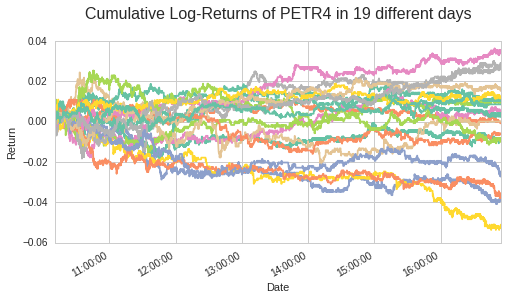

In [9]:
import numpy as np
df_logrtn = np.log(df_all/df_all.shift())
df_logrtn = df_logrtn[[(x.hour*60 + x.minute) < (16*60 + 55) for x in df_logrtn.index]]
ax = df_logrtn.cumsum().plot(legend=False)
ax.set_title('Cumulative Log-Returns of PETR4 in 19 different days\n', fontsize=16)
ax.set_ylabel('Return');

In [10]:
def measure_e_n(row, last_best):
    '''
    Measure the e_n of the current event
    :param row: dictionary. current row from the file
    :param last_best: tuple. best price and best quantity
    '''
    e_n = 0
    if row['Type'] == 'BID':
        e_n += (row['Price'] >= last_best[0]) * row['Size']
        e_n -= (row['Price'] <= last_best[0]) * last_best[1]
    elif row['Type'] == 'ASK':
        e_n -= (row['Price'] <= last_best[0]) * row['Size']
        e_n += (row['Price'] >= last_best[0]) * last_best[1]
    return e_n

def convert_float_to_time(f_time):
    '''
    Converst number of seconds in string time format
    '''
    i_hour = int(f_time / 3600)
    i_minute = int((f_time - i_hour * 3600) / 60)
    i_seconds = int((f_time - i_hour * 3600 - i_minute *60 ))
    return '{:02d}:{:02d}:{:02d}'.format(i_hour, i_minute, i_seconds)

In [15]:
import zipfile
import csv
import time
import numpy as np

f_start = time.time()
s_fname = "data/petr4_0725_0818_2.zip"
fw_out = open('data/ofi_petr.txt', 'w')
fw_out.write('TIME\tOFI\tDELTA_MID\tLOG_RET\n')
archive = zipfile.ZipFile(s_fname, 'r')
f_total = 0.
f_tot_rows = 0.
d_best_price = {'BID': (0., 0.), 'ASK': (0., 0.)}
f_min_time = 10.  # em segundos

# le cada arquivo dentro do arquivo zip (neste caso, ha apenas 1 arquivo)
x = l_fnames[0]
f_ofi = 0.
f_mid = None
f_next_time = 10 * 3600 + 5 * 60 + f_min_time
for idx_row, row in enumerate(csv.DictReader(archive.open(x))):
    if idx_row == 0:
        f_first_price = row['Price']
    # nao preciso lidar com os trades, pois jah esta refletido no bid e ask
    if row['Type'] in ['BID', 'ASK']:
        # converte string para float
        row['Price'] = float(row['Price'].replace(',', '.')) 
        row['Size'] = float(row['Size'])
        f_current_time = sum([float(x)*60**(2.-i_aux)  for i_aux, x in enumerate(row['Date'][-8:].split(":"))])
        if f_current_time > f_next_time:
            # imprime resultado
            s_time = convert_float_to_time(f_next_time)
            f_change = 0
            f_logrtn = 0.
            if f_mid:
                f_curent_mid = (d_best_price['ASK'][0] + d_best_price['BID'][0])/2.
                f_change = int((f_curent_mid - f_mid)/0.01)
                f_logrtn = np.log((f_curent_mid/f_mid))
            f_mid = (d_best_price['ASK'][0] + d_best_price['BID'][0])/2.
            s_out = '{}\t{}\t{}\t{}\n'.format(s_time, f_ofi, f_change, f_logrtn)              
            fw_out.write(s_out)
            # zera valor
            f_ofi = 0
             # imprime de 10 em 10 s
            f_next_time  = (int(f_current_time/f_min_time) + 1)*f_min_time
        elif abs(f_current_time - f_next_time) > 3600:
            # new day
            f_next_time = 10 * 3600 + 5 * 60 + f_min_time
            f_mid = None
            f_ofi = 0
        # compara com valor anterior
        last_best = d_best_price[row['Type']]
        f_e_n = measure_e_n(row, last_best)
        # atualiza last best
        d_best_price[row['Type']] = (row['Price'], row['Size'])
        row['Date'] = row['Date'][-8:]
        f_ofi += f_e_n
            
            
             
    
print 'Time to process: {:0.2f} s'.format(time.time() - f_start)

Time to process: 2.52 s


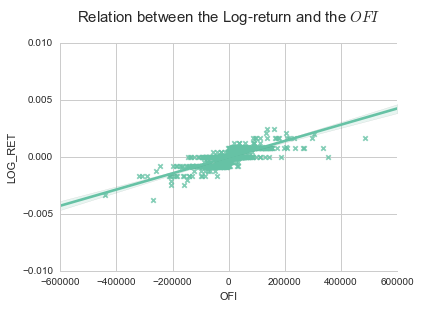

In [18]:
import pandas as pd
df = pd.read_csv('data/ofi_petr.txt', sep='\t')
df.drop('TIME', axis=1, inplace=True)
df.dropna(inplace=True)
ax = sns.lmplot(x="OFI", y="LOG_RET", data=df, markers=["x"], palette="Set2", size=4, aspect=1.5)
ax.ax.set_title(u'Relation between the Log-return and the $OFI$\n', fontsize=15);

According to \cite{Mitchell}, there are some conditions to ensure that the algorithm converges toward an optimal policy. On a deterministic MDP, the agent must select actions in a way that it visits every possible state-action pair infinitely often. 

As the most inputs suggested in the representation of the environment are continuos variables, in the section 3 I will discretize those numbers.

### 2.2. Algorithms and Techniques
```
Udacity:

In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- Are the algorithms you will use, including any default variables/parameters in the project clearly defined?
- Are the techniques to be used thoroughly discussed and justified?
- Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?
```
As explained by \cite{Mohri_2012}, reinforcement learning is the study of planning and learning in a scenario where a learner (or agent) actively interacts with the environment to achieve a particular goal. The achievement of the agent's goal is typically measured by the reward he receives from the environment and which he seeks to maximize.

\cite{Kaelbling_1996} state that the most significant difference between reinforcement learning and supervised learning is that there is no presentation of input/output pairs. Instead, they explained that after choosing an action, the agent is told the immediate reward and the following state, but is not told which action would have been in its best long-term interests. It is necessary for the agent to gather useful experience about the possible system states, actions, transitions and rewards actively to act optimally.

Defining a general formulation of the problem based on a Markov Decision Process (MDP), as proposed by \cite{Mitchell}, the agent can perceive a set $S$ os distinct states of its environment and has a set $A$ of actions that it can perform. So, at each discrete time step $t$, the agent senses the current state $s_t$ and choose to take an action $a_t$. The environment responds by providing the agent a reward $r_t=r(s_t, a_t)$ and by producing the succeeding state $s_{t+1}=\delta(s_t, a_t)$. The functions $r$ and $\delta$ only depend on the current state and action (it is [memoryless](https://en.wikipedia.org/wiki/Markov_process)), are part of the environment and are not necessarily known to the agent.

The task of the agent is to learn a policy $\pi$ that maps each state to an action ($\pi: S \rightarrow A$), selecting its next action $a_t$ based solely on the current observed state $s_t$, that is $\pi(s_t)=a_t$. The optimal policy, or control strategy, is the one that produces the greatest possible cumulative reward over time. So, stating that:

$$V^{\pi}(s_t)= r_t + \gamma r_{t+1} + \gamma^2 r_{t+1} + ... = \sum_{i=0}^{\infty} \gamma^{i} r_{t+i}$$

Where $V^{\pi}(s_t)$ is also called the discounted cumulative reward and it represents the cumulative value achieved by following an policy $\pi$ from an initial state $s_t$ and $\gamma \in [0, 1]$ is a constant that determines the relative value of delayed versus immediate rewards. If we set $\gamma=0$, only immediate rewards is considered. As $\gamma \rightarrow 1$, future rewards are given greater emphasis relative to immediate reward. The optimal policy $\pi^{*}$ that will maximizes $V^{\pi}(s_t)$ for all states $s$ can be written as:

$$\pi^{*} = \underset{\pi}{\arg \max} \, V^{\pi} (s)\,\,\,\,\,, \,\, \forall s$$

As learning $\pi^{*}: S \rightarrow A$ directly is difficult because the available training data does not provide training examples of the form $(s, a)$, in the section 3 I will implement the Q-learning algorithm for estimating the optimal policy.

### 2.3. Benchmark
```
Udacity:

In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- Has some result or value been provided that acts as a benchmark for measuring performance?
- Is it clear how this result or value was obtained (whether by data or by hypothesis)?
```

As described before, the random agent should select a random action form a set of valid action at each time step $t$. The set of action can change because the random agent is also limited to hold an open position of $400$ stocks at most, on any side. When it reaches its limit, it will be allowed just to perform actions that decrease its position. So, for instance, if it already [long](http://www.investopedia.com/terms/l/long.asp) in $400$ shares, the possible moves would be $\left (None,\, sell,\, best\_ask \right)$. If it is [short](http://www.investopedia.com/terms/s/short.asp), it just can perfrom $\left (None,\, buy,\, best\_bid\right)$.

## 3. Methodology
_(approx. 3-5 pages)_

### 3.1 Data Preprocessing
```
Udacity:

In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?
- Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?
- If no preprocessing is needed, has it been made clear why?
```





\cite{Mohri_2012} explained that reinforcement learning is the study of planning and learning in a scenario where a learner (or agent) actively interacts with the environment to achieve a particular goal. The achievement of the agent's objective is typically measured by the reward he receives from the environment and which he seeks to maximize. Therefore, as \cite{chan2001electronic} described, the knowledge of the underlying process is not assumed but learned from experience.






...

 the number of ticks that the mid-price has changed

...


The learner should receive the inputs mentioned above at each time step $t$, and generate one of the following six possible actions: insert an order (or keep) just at the **best_bid price**, just at the **best_ask** price, on both sides (**best_both**) or cancel all its orders (**None**). It also can **buy** (take the ask, in the market jargon), or **sell** (hit the bid).

....

Each learning session will include data from the largest part of a trading session, starting at 10:30 and closing at 16:30. Also, the agent will be allowed to hold a position of just 400 shares at maximum (buy or sell). When the learning session is over, all positions from the learner will be closed out so the agent always will start a new session without carrying stocks.

### 3.2. Implementation

```
Udacity:

In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?
- Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?
- Was there any part of the coding process (e.g., writing complicated functions) that should be documented?
```

#### 3.2.1. The Q-Function

As mention before, to learn an optimal policy $\pi^{*}$, I can't learn a function $\pi^{*}: S \rightarrow A$ that maps a state to the optimal action directly. There is no such information upfront to be used as training data. Instead, as \cite{Mitchell} explained, the only available information is the sequence of immediate rewards $r(s_i, a_i)$ for $i=1,\, 2,\, 3,\,...$

So, as we are trying to maximize the cumulative rewards $V^{*}(s_t)$ for all states $s$, the agent should prefer $s_1$ over $s_2$ wherever $V^{*}(s_1) > V^{*}(s_2)$. Given that the agent must choose among actions and not states, and it isn't able to perfectly predict the immediate reward and immediate successor for every possible state-action transition, we also must learn $V^{*}$ indirectly.

To solve that, we define a function $Q(s, \, a)$ such that its value is the maximum discounted cumulative reward that can be achieved starting from state $s$ and applying action $a$ as the first action. So, we can write:

$$Q(s, \, a) = r(s, a) + \gamma V^{*}(\delta(s, a))$$

As $\delta(s, a)$ is the state resulting from applying action $a$ to state $s$ (the successor) chosen by following the optimal policy, $V^{*}$ is the cumulative value of the immediate successor state discounted by a factor $\gamma$. Thus,  what we are trying to achieve is

$$\pi^{*}(s) = \underset{a}{\arg \max} Q(s, \, a)$$

Thus, the optimal policy can be obtained even if the agent just uses the current action $a$ and state $s$ and chooses the action that maximizes $Q(s,\, a)$. Also, it is important to notice that the function above implies that the agent can select optimal actions even when it has no knowledge of the functions $r$ and $\delta$. In the next subsection, we will see how \cite{Mitchell} defined a reliable way to estimate training values for $Q$, given only a sequence of immediate rewards $r$.


#### 3.2.2. Learning $Q$

As we have seen, learning the Q function corresponds to learning the optimal policy. According to \cite{Mohri_2012}, the optimal state-action value function $Q^{*}$ is defined for all $(s, \, a) \in S \times A$ as the expected return for taking the action $a \in A$ at the state $s \in S$, following the optimal policy. So, it can be written as \cite{Mitchell} suggested:

$$V^{*}(s) = \underset{a'}{\arg \max} Q(s, \, a')$$

Using this relationship, we can write a recursive definition of Q function, such that:

$$Q(s, \, a) = r(s, a) + \gamma \, \underset{a'}{\max} \, Q(\delta(s,\, a), \, a')$$

The recursive nature of the function above implies that our agent doesn't know the actual $Q$ function. It just can estimate $Q$, that we will refer as $\hat{Q}$. It will represents is hypothesis $\hat{Q}$ as a large table that attributes each pair $(s\, , \, a)$ to a value for $\hat{Q}(s,\, a)$ - the current hypothesis about the actual but unknown value $Q(s, \, a)$. I will initialize this table with zeros, but it could be filled with random numbers, according to \cite{Mitchell}. Still according to him, the agent repeatedly should observe its current state $s$ and do the following:
- Observe the current state $s$ and:
    - Choose some action $a$ and execute it
    - Receive the immediate reward $r = r(s, a)$
    - initialize the table entry $\hat{Q}(s, \, a)$ to zero if there is no entry $(s, \, a)$
    - Observe the new state $s' = \delta(s, \,a)$. 
    - Updates the table entry for $\hat{Q}(s, \, a)$ following:
        - $\hat{Q}(s, \, a) \leftarrow r + \gamma \underset{a'}{\max} \hat{Q}(s', \, a')$
- $s \leftarrow s'$
    
Note this training rule is suited to a deterministic Markov decision process (where $r(s,\, a)$ and $\delta(s,\, a)$ are deterministics) and uses the agent's current $\hat{Q}$ values for the new state $s'$ to refine its estimate of $\hat{Q}(s, \,a)$ for the previous state $s$. It is tricky. So, let's take a look at its performance.

### 3.3. Refinement
```
Udacity:

In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- Has an initial solution been found and clearly reported?
- Is the process of improvement clearly documented, such as what techniques were used?
- Are intermediate and final solutions clearly reported as the process is improved?
```

#### 3.3.1. Experimentation Strategies

One of the issues of the current strategy is that the agent could overcommit to actions that presented positive $\hat{Q}$ values early in the simulation, failing to explore other actions that could present even higher values. \cite{Mitchell} proposed to use a probabilistic approach to select actions, assigning higher probabilities to action with high $\hat{Q}$ values, but given to every action at least a nonzero probability. So, I will implement the following relation:

$$P(a_i\, | \,s ) = \frac{k ^{\hat{Q}(s, a_i)}}{\sum_j k^{\hat{Q}(s, a_j)}}$$

Where $P(a_i\, | \,s )$ is the probability of selecting the action $a_i$ given the state $s$. The constant $k$ is positive and determines how strongly the selection favors action with high $\hat{Q}$ values. Let's look at the number of times the algorithm choose to explore when we vary the value of the $k$.

#### 3.3.2. Nondeterministic Rewards and Actions

The last modification that I want to introduce is when the environment is non-deterministic. As I said before, the algorithm used is appropriate to the deterministic case. On a nondeterministic environment, the reward function $r(s,\,a)$ and action transition function $\delta(s,\,a)$ may have probabilistic outcomes. As there are other agents in the smartcab world, I believe that it is a proper assumption.

As explained by \cite{Mitchell}, to handle nondeterministic MDPs, it is needed to redefine the value $V^{*}$ to be expressed as a expected value. So, jumping to the $Q$ function, we can re-express $Q$ recursively as:

\begin{equation}
\begin{aligned}
Q(s, \, a) &= E \left [r(s, a) \right ] + E \left [\gamma \, \underset{a'}{\max} \, Q(\delta(s,\, a), \, a')\right ]\\
&= E \left [r(s, a) \right ] + \gamma \,  E \left [\underset{a'}{\max} \, Q(\delta(s,\, a), \, a')\right ]\\
&= E \left [r(s, a) \right ] + \gamma \,  \sum_{s'} P\left(s' \,| \,s, a   \right) \underset{a'}{\max} \, Q(\delta(s,\, a), \, a')
\end{aligned}
\end{equation}


Where $P\left(s' \,| \,s, a   \right)$ is the probability that taking action $a$ in state $s$ will produce the next state $s'$. To implement that, we need to assume that the $\hat{Q}$ values in our table may be wrong, due to the nondeterministic behavior of our environment. So, \cite{Mitchell} suggested to modifying the training rule by introducing a decaying weighted average factor to the current $\hat{Q}$ value and to the revised estimate, such that:

$$\hat{Q}(s, \, a) \leftarrow  (1 - \alpha_{n})\, \hat{Q}_{n-1}(s, \, a) +  \alpha_{n}\left[ r + \gamma \underset{a'}{\max} \hat{Q}_{n-1}(s', \, a') \right ]$$

Where $\alpha_{n} = \frac{1}{1 + visits_{n}(s, \,a)}$ is the decaying factor and $visits_{n}$ is the total number of times this state-action $(s, \, a)$ pair has been visited. So, let's put it in practice.


## 4. Results
_(approx. 2-3 pages)_

### 4.1. Model Evaluation and Validation
```
Udacity:

In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?
- Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?
- Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?
- Can results found from the model be trusted?
```

### 4.2. Justification
```
Udacity:

In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- Are the final results found stronger than the benchmark result reported earlier?
- Have you thoroughly analyzed and discussed the final solution?
- Is the final solution significant enough to have solved the problem?
```


## 5. Conclusion
_(approx. 1-2 pages)_

### 5.1. Free-Form Visualization
```
Udacity:

In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- Have you visualized a relevant or important quality about the problem, dataset, input data, or results?
- Is the visualization thoroughly analyzed and discussed?
- If a plot is provided, are the axes, title, and datum clearly defined?
```

### 5.2. Reflection
```
Udacity:

In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- Have you thoroughly summarized the entire process you used for this project?
- Were there any interesting aspects of the project?
- Were there any difficult aspects of the project?
- Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?
```

### 5.3. Improvement
```
Udacity:

In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- Are there further improvements that could be made on the algorithms or techniques you used in this project?
- Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?
- If you used your final solution as the new benchmark, do you think an even better solution exists?
```


*Style notebook and change matplotlib defaults*

In [2]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read())

In [1]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))